# Day 2: Regularization (Ridge & Lasso)
## Week 4: Machine Learning Foundations

---

### 🎯 Learning Objectives
- Understand overfitting and the bias-variance tradeoff
- Implement Ridge (L2) and Lasso (L1) regression
- Select regularization parameter via cross-validation
- Apply to financial factor selection

---

### 📈 Why Regularization Matters in Trading

**The Problem:** With many potential factors (100s of technical indicators), OLS overfits to noise.

**The Solution:** Regularization penalizes model complexity.

### Trading Applications

| Technique | Trading Use Case |
|-----------|------------------|
| **Ridge (L2)** | Factor models with correlated factors |
| **Lasso (L1)** | Automatic factor selection |
| **ElasticNet** | Best of both worlds |

### 🎯 When to Use Each Method

| Scenario | Best Method | Why |
|----------|-------------|-----|
| Many correlated factors | Ridge | Handles multicollinearity |
| Want sparse model | Lasso | Sets coefficients to zero |
| Feature selection needed | Lasso | Built-in selection |
| Prediction accuracy | Ridge | Usually lower MSE |
| Unknown which is better | ElasticNet | Combines both |

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1255 days


## 1. The Overfitting Problem

**Overfitting = Fitting to Noise = Losing Money**

### 🎯 Why Overfitting is Deadly in Trading

| Sign of Overfitting | What It Means |
|---------------------|---------------|
| High train R², low test R² | Model memorized noise |
| Many parameters | Too complex for data |
| Backtest >> Live | Classic overfitting |

### Financial Example

- **50 technical indicators** as features
- **100 days** of training data
- **Result:** OLS fits perfectly to training (R²=0.99) but predicts terribly on new data (R²<0)

### The Bias-Variance Tradeoff

| Model Complexity | Bias | Variance | Result |
|------------------|------|----------|--------|
| Too simple | High | Low | Underfitting |
| Just right | Low | Low | Optimal |
| Too complex | Low | High | Overfitting |

In [2]:
# Demonstrate overfitting
print("=" * 60)
print("THE OVERFITTING PROBLEM")
print("=" * 60)

# Many features, few samples scenario
np.random.seed(42)
n_samples = 100
n_features = 50

# Generate random features (mostly noise)
X_noise = np.random.randn(n_samples, n_features)

# Target depends on only a few features
y = 2 * X_noise[:, 0] - 1.5 * X_noise[:, 1] + 0.5 * X_noise[:, 2] + np.random.randn(n_samples) * 0.5

# Split
train_size = 70
X_train, X_test = X_noise[:train_size], X_noise[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# OLS
ols = LinearRegression()
ols.fit(X_train, y_train)

train_r2 = ols.score(X_train, y_train)
test_r2 = ols.score(X_test, y_test)

print(f"\nOLS with {n_features} features, {train_size} training samples:")
print(f"  Training R²: {train_r2:.4f}")
print(f"  Test R²:     {test_r2:.4f}")
print(f"\n⚠️ OVERFITTING: Train R² high, Test R² low (or negative!)")

# Coefficient magnitude
print(f"\nCoefficient statistics:")
print(f"  Mean |coef|:  {np.abs(ols.coef_).mean():.4f}")
print(f"  Max |coef|:   {np.abs(ols.coef_).max():.4f}")
print(f"\n💡 Large coefficients = high variance = overfitting")

THE OVERFITTING PROBLEM

OLS with 50 features, 70 training samples:
  Training R²: 0.9881
  Test R²:     0.9129

⚠️ OVERFITTING: Train R² high, Test R² low (or negative!)

Coefficient statistics:
  Mean |coef|:  0.1652
  Max |coef|:   2.0252

💡 Large coefficients = high variance = overfitting


## 2. Ridge Regression (L2)

### The Ridge Objective
$$\min_\beta \|y - X\beta\|^2 + \lambda \|\beta\|^2$$

### 🎯 Trading Interpretation

| Effect | Trading Benefit |
|--------|-----------------|
| Shrinks all coefficients | Reduces impact of noisy factors |
| Never sets to exactly zero | Keeps all factors in model |
| Handles multicollinearity | Works when factors are correlated |

### Choosing λ (Regularization Strength)

| λ Value | Effect | When to Use |
|---------|--------|-------------|
| λ = 0 | Pure OLS | Perfect data (never in finance) |
| Small λ | Slight shrinkage | Few factors, lots of data |
| Large λ | Strong shrinkage | Many factors, little data |

### Key Insight

**Ridge coefficients NEVER become exactly zero** - all factors stay in the model, just with smaller weights.

RIDGE REGRESSION (L2)

   Alpha  Train R²  Test R²  Mean |coef|
   0.001  0.988118 0.912899     0.165143
   0.010  0.988118 0.913323     0.164938
   0.100  0.988106 0.917280     0.162934
   1.000  0.987224 0.937334     0.148438
  10.000  0.962692 0.854907     0.127161
 100.000  0.682667 0.444902     0.078398
1000.000  0.164762 0.086366     0.016202


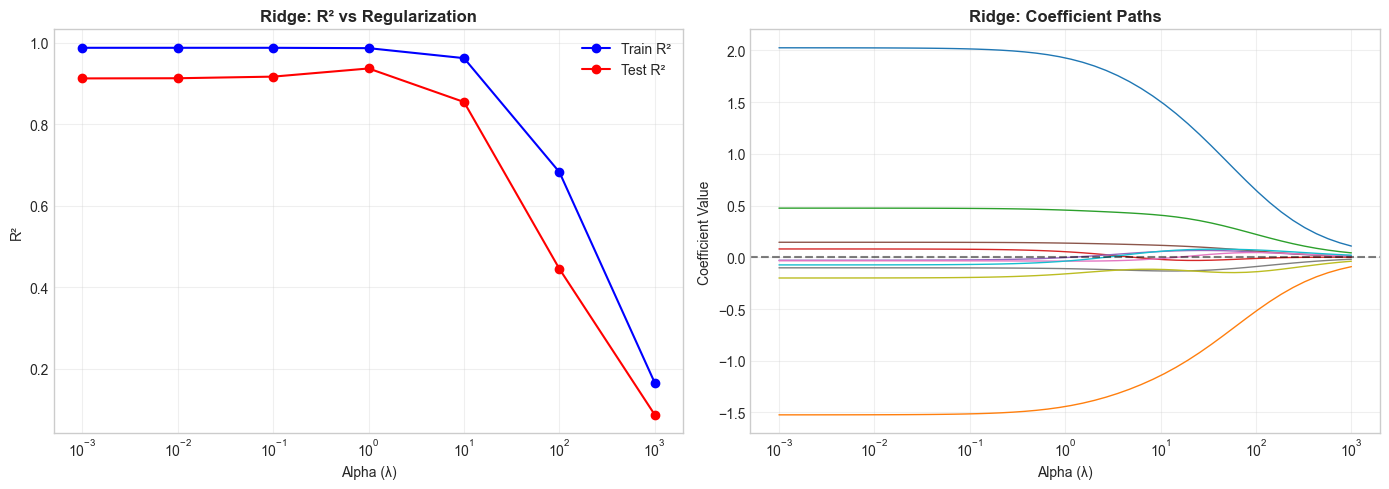

In [3]:
# Ridge Regression
print("=" * 60)
print("RIDGE REGRESSION (L2)")
print("=" * 60)

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

results = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    
    train_r2 = ridge.score(X_train, y_train)
    test_r2 = ridge.score(X_test, y_test)
    
    results.append({
        'Alpha': alpha,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Mean |coef|': np.abs(ridge.coef_).mean()
    })

results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² vs Alpha
axes[0].semilogx(results_df['Alpha'], results_df['Train R²'], 'b-o', label='Train R²')
axes[0].semilogx(results_df['Alpha'], results_df['Test R²'], 'r-o', label='Test R²')
axes[0].set_xlabel('Alpha (λ)')
axes[0].set_ylabel('R²')
axes[0].set_title('Ridge: R² vs Regularization', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Coefficient paths
coefs = []
for alpha in np.logspace(-3, 3, 50):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)
for i in range(min(10, n_features)):
    axes[1].semilogx(np.logspace(-3, 3, 50), coefs[:, i], lw=1)

axes[1].set_xlabel('Alpha (λ)')
axes[1].set_ylabel('Coefficient Value')
axes[1].set_title('Ridge: Coefficient Paths', fontweight='bold')
axes[1].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Lasso Regression (L1)

### The Lasso Objective
$$\min_\beta \|y - X\beta\|^2 + \lambda \|\beta\|_1$$

### 🎯 Trading Interpretation

| Effect | Trading Benefit |
|--------|-----------------|
| Sets some coefficients to zero | Automatic factor selection |
| Sparse models | Interpretable, fewer factors to track |
| Feature selection | Find which indicators actually matter |

### Trading Application: Factor Selection

Start with 100 technical indicators → Lasso selects 5-10 that actually matter

**Result:** Simpler model, easier to interpret, often better out-of-sample

### Lasso vs Ridge: Which Factors Survive?

| Method | Number of Factors | Factor Coefficients |
|--------|-------------------|---------------------|
| OLS | All (overfits) | Large, unstable |
| Ridge | All (shrunk) | Small, stable |
| Lasso | Few (selected) | Some zero, some significant |

LASSO REGRESSION (L1)

 Alpha  Train R²   Test R²  Non-zero coefs
 0.001  0.988046  0.924983              48
 0.010  0.985148  0.961777              38
 0.100  0.958430  0.945350              10
 0.500  0.830223  0.814577               3
 1.000  0.544590  0.535306               2
 2.000  0.000000 -0.000077               0
 5.000  0.000000 -0.000077               0


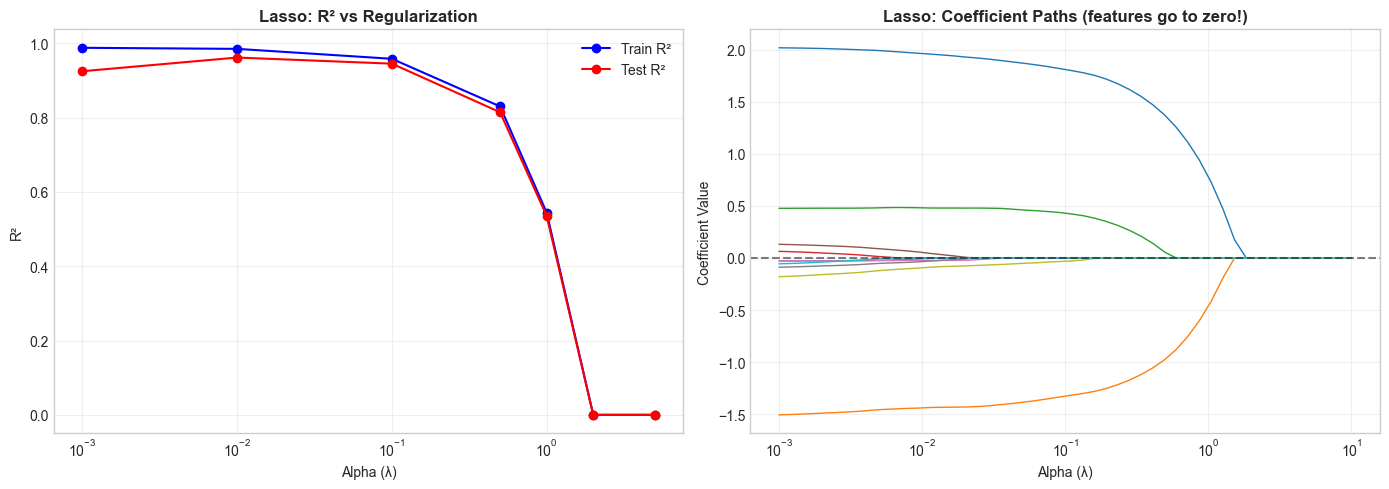


💡 Lasso performs automatic feature selection!


In [4]:
# Lasso Regression
print("=" * 60)
print("LASSO REGRESSION (L1)")
print("=" * 60)

alphas = [0.001, 0.01, 0.1, 0.5, 1, 2, 5]

results = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    train_r2 = lasso.score(X_train, y_train)
    test_r2 = lasso.score(X_test, y_test)
    n_nonzero = np.sum(lasso.coef_ != 0)
    
    results.append({
        'Alpha': alpha,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Non-zero coefs': n_nonzero
    })

results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² vs Alpha
axes[0].semilogx(results_df['Alpha'], results_df['Train R²'], 'b-o', label='Train R²')
axes[0].semilogx(results_df['Alpha'], results_df['Test R²'], 'r-o', label='Test R²')
axes[0].set_xlabel('Alpha (λ)')
axes[0].set_ylabel('R²')
axes[0].set_title('Lasso: R² vs Regularization', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Coefficient paths
coefs = []
alphas_plot = np.logspace(-3, 1, 50)
for alpha in alphas_plot:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)
for i in range(min(10, n_features)):
    axes[1].semilogx(alphas_plot, coefs[:, i], lw=1)

axes[1].set_xlabel('Alpha (λ)')
axes[1].set_ylabel('Coefficient Value')
axes[1].set_title('Lasso: Coefficient Paths (features go to zero!)', fontweight='bold')
axes[1].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Lasso performs automatic feature selection!")

## 4. Financial Application: Factor Selection

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1255 days


In [6]:
# Apply to real financial data
print("=" * 60)
print("FINANCIAL APPLICATION: FACTOR SELECTION")
print("=" * 60)

# Use multiple stocks as "factors" to predict one stock
target = 'AAPL'
features = [col for col in returns.columns if col != target][:20]  # Limit to 20

X = returns[features].values
y = returns[target].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time series split
split = int(len(X) * 0.8)
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y[:split], y[split:]

# Compare models
models = {
    'OLS': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
}

print(f"\nPredicting {target} returns using {len(features)} stock factors")
print("-" * 60)

for name, model in models.items():
    model.fit(X_train, y_train)
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    
    if hasattr(model, 'coef_'):
        n_nonzero = np.sum(np.abs(model.coef_) > 1e-6)
    else:
        n_nonzero = len(features)
    
    print(f"{name:12}: Train R²={train_r2:.4f}, Test R²={test_r2:.4f}, Features={n_nonzero}")

# Show Lasso selected features
lasso = Lasso(alpha=0.05, max_iter=10000)
lasso.fit(X_train, y_train)

selected = [(feat, coef) for feat, coef in zip(features, lasso.coef_) if abs(coef) > 1e-6]
selected.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"\nLasso selected features (α=0.05):")
for feat, coef in selected[:10]:
    print(f"  {feat:8}: {coef:+.4f}")

FINANCIAL APPLICATION: FACTOR SELECTION

Predicting AAPL returns using 3 stock factors
------------------------------------------------------------
OLS         : Train R²=0.4985, Test R²=0.3547, Features=3
Ridge       : Train R²=0.4985, Test R²=0.3548, Features=3
Lasso       : Train R²=0.0000, Test R²=-0.0000, Features=0
ElasticNet  : Train R²=0.0000, Test R²=-0.0000, Features=0

Lasso selected features (α=0.05):


In [7]:
# Cross-validation for alpha selection
print("=" * 60)
print("CROSS-VALIDATION FOR ALPHA SELECTION")
print("=" * 60)

from sklearn.linear_model import RidgeCV, LassoCV

# Ridge CV
ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5)
ridge_cv.fit(X_train, y_train)
print(f"\nRidge optimal α: {ridge_cv.alpha_:.4f}")
print(f"  Test R²: {ridge_cv.score(X_test, y_test):.4f}")

# Lasso CV
lasso_cv = LassoCV(alphas=np.logspace(-3, 1, 50), cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)
print(f"\nLasso optimal α: {lasso_cv.alpha_:.4f}")
print(f"  Test R²: {lasso_cv.score(X_test, y_test):.4f}")
print(f"  Non-zero coefficients: {np.sum(lasso_cv.coef_ != 0)}")

CROSS-VALIDATION FOR ALPHA SELECTION

Ridge optimal α: 59.6362
  Test R²: 0.3566

Lasso optimal α: 0.0010
  Test R²: 0.3315
  Non-zero coefficients: 3


## 📝 Key Takeaways - Day 2

### Regularization Comparison:

| Method | Penalty | Effect | Use Case |
|--------|---------|--------|----------|
| Ridge (L2) | λΣβ² | Shrinks all | Multicollinearity |
| Lasso (L1) | λΣ|β| | Sets some to 0 | Feature selection |
| ElasticNet | Both | Combined | Best of both |

### When to Use:
- **Ridge**: Many correlated features, all may be relevant
- **Lasso**: Suspect many features are irrelevant
- **ElasticNet**: Groups of correlated features

### Key Insight:
In finance, Lasso is often preferred because:
- Interpretability (fewer factors)
- Built-in factor selection
- Prevents overfitting to noise

### Interview Questions:
- "What's the difference between L1 and L2 regularization?"
- "Why does Lasso produce sparse solutions?"
- "How do you choose the regularization parameter?"

## 🔴 PROS & CONS: Regularization

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [8]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Regularization Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-23 00:09

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $250.20
   GOOGL: $331.12
   JPM: $304.97
   MSFT: $451.86

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.13%
   🟢 GOOGL: +5.33%
   🔴 JPM: -6.01%
   🔴 MSFT: -7.19%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟢 BULLISH - Consider long positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
